# Import libraries and generate data

In [1]:
import numpy as np

# Seed
np.random.seed(42)

# Simulate some data
n, p = 100, 10  # Number of observations and features
X = np.random.randn(n, p)
Xsub = X[:,:5]
print(X.shape)

true_beta = np.random.randn(5).reshape(-1,1)
y = np.matmul(Xsub, true_beta) + 0.5 * np.random.randn(n).reshape(-1,1)  # Adding some noise
print(y.shape)

(100, 10)
(100, 1)


In [2]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Pipeline and some hyperparameters

In [3]:
# Create a pipeline that standardizes the data then fits the Lasso model
lambda_ = 0.5
lasso_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=lambda_, fit_intercept=True))

# Fit using `sklearn`

In [4]:
# Fit the model
lasso_pipeline.fit(X, y.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.5))])

# Get results

In [5]:
# Get the estimated coefficients and intercept
lasso_model = lasso_pipeline.named_steps['lasso']
beta_estimated = lasso_model.coef_
intercept = lasso_model.intercept_

# Print the estimated coefficients and intercept
print("Intercept:", intercept)
print("Estimated coefficients:", beta_estimated)
print("True coefficients:", true_beta)

Intercept: 0.06326823555397833
Estimated coefficients: [ 0.65095652  0.42377436  0.         -0.29798286  0.29193259 -0.
 -0.          0.         -0.         -0.        ]
True coefficients: [[ 1.39935544]
 [ 0.92463368]
 [ 0.05963037]
 [-0.64693678]
 [ 0.69822331]]


# Fit using cross-validation

In [6]:
from sklearn.linear_model import LassoCV

In [7]:
# Create a pipeline with standardization and LassoCV
lasso_cv_pipeline = make_pipeline(
    StandardScaler(),
    LassoCV(cv=5, random_state=42)  # 5-fold cross-validation
)

In [8]:
# Fit the pipeline
lasso_cv_pipeline.fit(X, y.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv', LassoCV(cv=5, random_state=42))])

In [9]:
# Retrieve the fitted LassoCV model
lasso_cv_model = lasso_cv_pipeline.named_steps['lassocv']

In [10]:
# Get the optimal alpha (lambda)
optimal_alpha = lasso_cv_model.alpha_

# Get the estimated coefficients and intercept
beta_estimated = lasso_cv_model.coef_
intercept = lasso_cv_model.intercept_

# Print the results
print("Optimal alpha (lambda):", optimal_alpha)
print("Intercept:", intercept)
print("Estimated coefficients:", beta_estimated)
print("True coefficients:", true_beta)

Optimal alpha (lambda): 0.05215236729770639
Intercept: 0.06326823555397834
Estimated coefficients: [ 1.12083159  0.84104746  0.04218801 -0.68778333  0.67293769 -0.00344116
  0.         -0.         -0.         -0.        ]
True coefficients: [[ 1.39935544]
 [ 0.92463368]
 [ 0.05963037]
 [-0.64693678]
 [ 0.69822331]]


# Implement coordinate descent

In [11]:
def soft_thresholding(x, lambda_):
    if x > 0 and lambda_ < np.abs(x):
        return x - lambda_
    elif x < 0 and lambda_ < np.abs(x):
        return x + lambda_
    else:
        return 0

def coordinate_descent_lasso_with_intercept(X, y, lambda_, num_iterations=1000, tol=1e-6):
    n, p = X.shape
    # Standardize X and center y
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0, ddof=0)
    y_mean = np.mean(y)
    
    X_std[X_std == 0] = 1  # To avoid division by zero for constant columns
    X_scaled = (X - X_mean) / X_std
    y_centered = y - y_mean

    beta = np.zeros(p)
    for iteration in range(num_iterations):
        beta_old = beta.copy()
        for j in range(p):
            residual = y_centered - X_scaled @ beta + beta[j] * X_scaled[:, j]
            rho = X_scaled[:, j].T @ residual
            beta[j] = soft_thresholding(rho / (X_scaled[:, j].T @ X_scaled[:, j]), lambda_)
        # Check for convergence (change in coefficients)
        if np.linalg.norm(beta - beta_old, ord=2) < tol:
            print(f"Converged after {iteration + 1} iterations")
            break

    # Compute the intercept using the non-centered response
    intercept = y_mean - np.mean(X, axis=0) @ beta
    return intercept, beta

# Fit lasso with coordinate descent

In [12]:
# Run the coordinate descent algorithm 
intercept, beta_estimated = coordinate_descent_lasso_with_intercept(X, y.ravel(), lambda_)

# Print the estimated coefficients and intercept
print("Intercept:", intercept)
print("Estimated coefficients:", beta_estimated)
print("True coefficients:", true_beta)

Converged after 5 iterations
Intercept: 0.06908491318685492
Estimated coefficients: [ 0.65095709  0.42377457  0.         -0.29798286  0.29193257  0.
  0.          0.          0.          0.        ]
True coefficients: [[ 1.39935544]
 [ 0.92463368]
 [ 0.05963037]
 [-0.64693678]
 [ 0.69822331]]


# Compare with `sklearn`

In [13]:
lambda_ = 0.5
lasso_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=lambda_, fit_intercept=True))

lasso_pipeline.fit(X, y.ravel())

lasso_model = lasso_pipeline.named_steps['lasso']
beta_estimated2 = lasso_model.coef_
intercept2 = lasso_model.intercept_

print("Intercept:", intercept2)
print("Estimated coefficients:", beta_estimated2)
print("True coefficients:", true_beta)

Intercept: 0.06326823555397833
Estimated coefficients: [ 0.65095652  0.42377436  0.         -0.29798286  0.29193259 -0.
 -0.          0.         -0.         -0.        ]
True coefficients: [[ 1.39935544]
 [ 0.92463368]
 [ 0.05963037]
 [-0.64693678]
 [ 0.69822331]]


In [31]:
def coordinate_descent_lasso_with_intercept_with_history(X, y, lambda_, num_iterations=1000, tol=1e-6):
    n, p = X.shape
    # Standardize X and center y
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0, ddof=0)
    y_mean = np.mean(y)
    
    X_std[X_std == 0] = 1  # To avoid division by zero for constant columns
    X_scaled = (X - X_mean) / X_std
    y_centered = y - y_mean

    beta = np.zeros(p)
    beta_hist = np.zeros(shape = (1, p))
    beta_hist_all = np.zeros(shape=(1,p))
    for iteration in range(num_iterations):
        beta_old = beta.copy()
        for j in range(p):
            residual = y_centered - X_scaled @ beta + beta[j] * X_scaled[:, j]
            rho = X_scaled[:, j].T @ residual
            beta[j] = soft_thresholding(rho / (X_scaled[:, j].T @ X_scaled[:, j]), lambda_)
            beta_hist_all = np.concatenate((beta_hist_all, beta.reshape(1,-1)), axis=0)
        # Check for convergence (change in coefficients)
        beta_hist = np.concatenate((beta_hist, beta.reshape(1,-1)), axis=0)
        if np.linalg.norm(beta - beta_old, ord=2) < tol:
            print(f"Converged after {iteration + 1} iterations")
            break

    # Compute the intercept using the non-centered response
    intercept = y_mean - np.mean(X, axis=0) @ beta
    return intercept, beta, beta_hist, beta_hist_all

In [32]:
# Run the coordinate descent algorithm 
intercept, beta_estimated, beta_hist, beta_hist_all = coordinate_descent_lasso_with_intercept_with_history(X, y.ravel(), lambda_)

# Print the estimated coefficients and intercept
print("Intercept:", intercept)
print("Estimated coefficients:", beta_estimated)
print("True coefficients:", true_beta)

Converged after 5 iterations
Intercept: 0.06908491318685492
Estimated coefficients: [ 0.65095709  0.42377457  0.         -0.29798286  0.29193257  0.
  0.          0.          0.          0.        ]
True coefficients: [[ 1.39935544]
 [ 0.92463368]
 [ 0.05963037]
 [-0.64693678]
 [ 0.69822331]]


In [33]:
beta_hist.shape

(6, 10)

In [34]:
import matplotlib.pyplot as plt

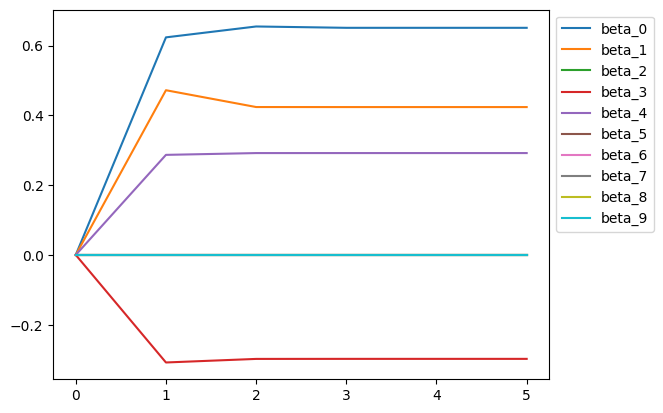

In [37]:
plt.figure()
for i in range(beta_hist.shape[1]):
    all_beta_i = beta_hist[:,i]
    plt.plot(all_beta_i, label = f'beta_{i}')
plt.legend(bbox_to_anchor = (1,1))
plt.show()

In [38]:
beta_hist_all.shape

(51, 10)

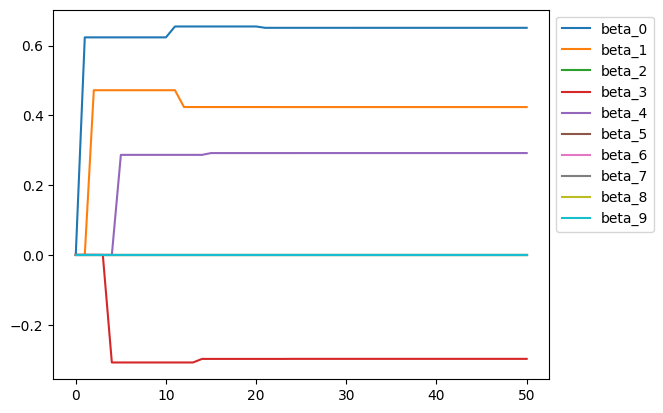

In [39]:
plt.figure()
for i in range(beta_hist_all.shape[1]):
    all_beta_i = beta_hist_all[:,i]
    plt.plot(all_beta_i, label = f'beta_{i}')
plt.legend(bbox_to_anchor = (1,1))
plt.show()